## Quantum Amplitude Estimation
Quantum amplitude estimation is a task of finding an estimate for amplitude a of a state |psi1>, since quantum amplitude estimation is expensive as it involves large circuits. We implement another variation of QAE considering a bernoulli random variable with success probablity p. 

We require some operator A such that:
A|0> = sqrt(1-p)|0> + sqrt(p) |1>

So A can be described as A = Ry(theta), where theta=2arcsin(sqrt(p))
The equivalent grover operator to find amplitude is simply Q = Ry(2*theta)

In [70]:
p = 0.3 # Fix p to 0.2

import numpy as np
from qiskit.circuit import QuantumCircuit



# Define the circuit A and Q described above as Bernoulli operator and GroverOperator
class BernoulliOperator(QuantumCircuit):
  def __init__(self, probablity):
    super().__init__(1) # Single qubit circuit
    self.__qubit_index = 0
    theta = 2 * np.arcsin(np.sqrt(probablity))
    self.ry(theta, self.__qubit_index)


class GroverOperator(QuantumCircuit):
  def __init__(self, probablity:float):
    super().__init__(1)
    self.__qubit_index = 0
    self.__theta = 2 * np.arcsin(np.sqrt(probablity))
    self.ry(2*self.__theta, self.__qubit_index)
  

  def power(self, k: int) -> QuantumCircuit:
    qc = QuantumCircuit(1)
    qc.ry(2 * k * self.__theta, self.__qubit_index)
    return qc
    
grover_operator = GroverOperator(p)
bernoulli_operator = BernoulliOperator(p)





Esimtated:0.1464466
Target:0.3
Not a good estimation for the target


/var/folders/_g/pnkjprqj7z3d7wwtd6jwl2fc0000gn/T/ipykernel_3517/3136389871.py:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


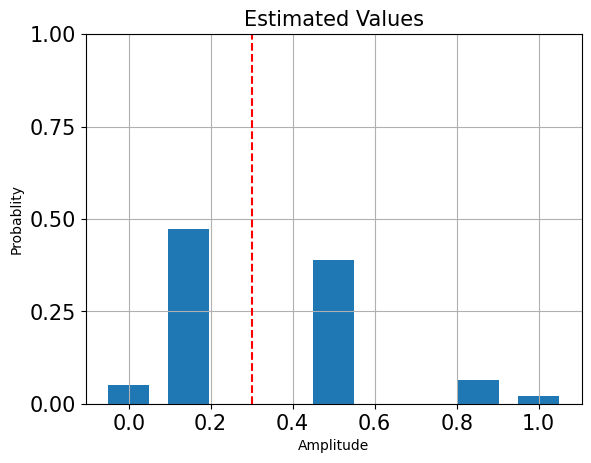

In [71]:

from qiskit_algorithms import EstimationProblem, AmplitudeEstimation
from qiskit.primitives import Sampler
import matplotlib.pyplot as plt

# Problem definition
problem = EstimationProblem(state_preparation=bernoulli_operator, objective_qubits=[0], grover_operator=grover_operator)
# Problem sampler
sampler = Sampler()
estimation = AmplitudeEstimation(num_eval_qubits=3, sampler=sampler)
estimation_result = estimation.estimate(problem)
print(f"Esimtated:{estimation_result.estimation}")
print(f"Target:{p}")
print("Not a good estimation for the target")


gridpoints = list(estimation_result.samples.keys())
probablities = list(estimation_result.samples.values())

plt.bar(gridpoints, probablities, width=0.5/len(probablities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0,0.25,0.5,0.75,1],size=15)
plt.title("Estimated Values", size=15)
plt.xlabel("Amplitude")
plt.ylabel("Probablity")
plt.grid()
plt.show()

In [72]:
print(f"Interpolated estimate: {estimation_result.mle}")

Interpolated estimate: 0.29999999862844184


In [73]:
amplitude_estimation_circuit = estimation.construct_circuit(estimation_problem=problem)
amplitude_estimation_circuit.decompose().draw()

┌───┐                                                      »
eval_0: ──────┤ H ├─────────────■────────────────────────────────────────»
              ├───┤             │                                        »
eval_1: ──────┤ H ├─────────────┼───────────────■────────────────────────»
              ├───┤             │               │                        »
eval_2: ──────┤ H ├─────────────┼───────────────┼───────────────■────────»
        ┌─────┴───┴─────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐»
     q: ┤ R(1.1593,π/2) ├┤ circuit-2851 ├┤ circuit-2860 ├┤ circuit-2869 ├»
        └───────────────┘└──────────────┘└──────────────┘└──────────────┘»
«        ┌──────────┐
«eval_0: ┤2         ├
«        │          │
«eval_1: ┤1 IQFT_dg ├
«        │          │
«eval_2: ┤0         ├
«        └──────────┘
«     q: ────────────
«

We try other different estimation methods to find the best model:

In [74]:
from qiskit_algorithms import IterativeAmplitudeEstimation

target_accuracy = 0.01 # 99% accurate
significance = 0.05 # 95% confidence
iae = IterativeAmplitudeEstimation(epsilon_target=target_accuracy, alpha=significance, sampler=sampler)
iae_result = iae.estimate(problem)
print("Estimation result:", iae_result.estimation)
print("Target estimation:", p)

circuit = iae.construct_circuit(problem)
circuit.decompose().draw()


Estimation result: 0.3
Target estimation: 0.3


┌───────────────┐
q: ┤ R(1.1593,π/2) ├
   └───────────────┘

In [75]:
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation

log2maxgroverpower = 3
mlae = MaximumLikelihoodAmplitudeEstimation(evaluation_schedule=log2maxgroverpower, sampler=sampler)
result = mlae.estimate(problem)
print("Result estimate:",result.estimation)
print("Actual Target:",p)


circuits = mlae.construct_circuits(problem)
for i,qc in enumerate(circuits):
  print("Circuit", i)
  print(qc.decompose().draw())

Result estimate: 0.29999255431916677
Actual Target: 0.3
Circuit 0
   ┌───────────────┐
q: ┤ R(1.1593,π/2) ├
   └───────────────┘
Circuit 1
   ┌───────────────┐┌───────────────┐
q: ┤ R(1.1593,π/2) ├┤ R(2.3186,π/2) ├
   └───────────────┘└───────────────┘
Circuit 2
   ┌───────────────┐┌───────────────┐
q: ┤ R(1.1593,π/2) ├┤ R(4.6371,π/2) ├
   └───────────────┘└───────────────┘
Circuit 3
   ┌───────────────┐┌───────────────┐
q: ┤ R(1.1593,π/2) ├┤ R(9.2742,π/2) ├
   └───────────────┘└───────────────┘


In [76]:
from qiskit_algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(delta=target_accuracy, sampler=sampler, maxiter=log2maxgroverpower)
estimation_result = fae.estimate(problem)
print("Result estimate:", estimation_result.estimation)
print("Actual target:", p)

Result estimate: 0.30541011514891236
Actual target: 0.3


Lets construct a graph for the various probablities values and accuracy of the different models

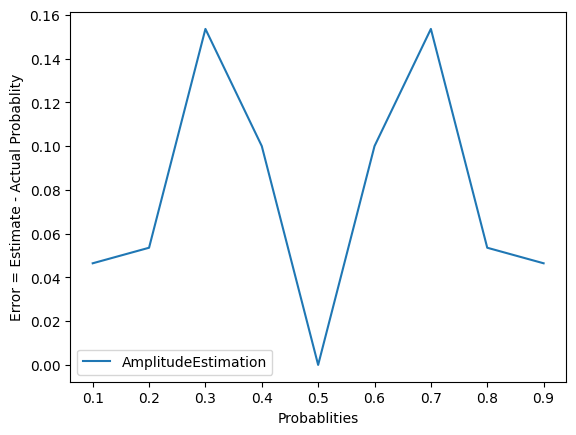

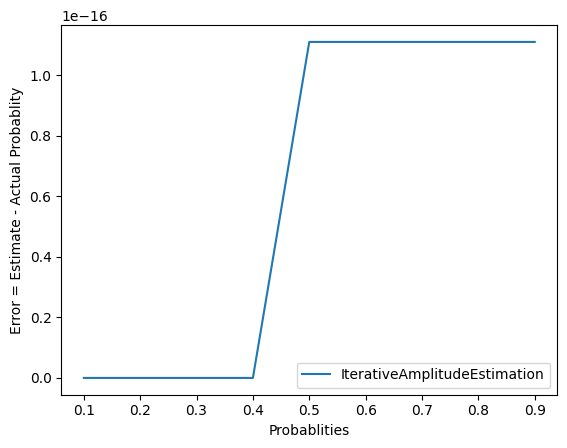

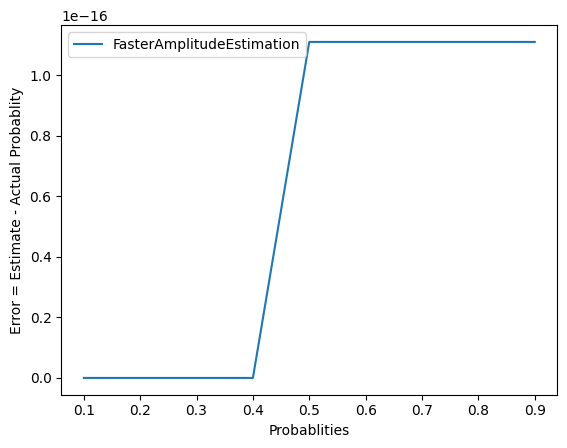

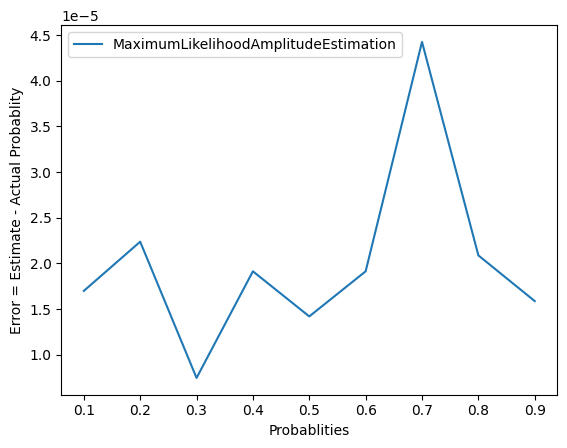

In [83]:


mlae_errors = []
fae_errors = []
iae_errors = []
ae_errors = []
x = []
for p in range(10, 100, 10):
  prob = p/100
  x.append(prob)

  grover_operator = GroverOperator(prob)
  bernoulli_operator = BernoulliOperator(prob)

  problem = EstimationProblem(state_preparation=bernoulli_operator, objective_qubits=[0], grover_operator=grover_operator)


  estimation = AmplitudeEstimation(num_eval_qubits=3, sampler=sampler)
  result = estimation.estimate(problem)
  error = abs(prob - result.estimation)
  ae_errors.append(error)

  iae = IterativeAmplitudeEstimation(epsilon_target=target_accuracy, alpha=significance, sampler=sampler)
  result = iae.estimate(problem)
  error = abs(prob - result.estimation)
  iae_errors.append(error)

  fae = FasterAmplitudeEstimation(delta=target_accuracy, sampler=sampler, maxiter=log2maxgroverpower)
  estimation_result = fae.estimate(problem)
  error = abs(prob - result.estimation)
  fae_errors.append(error)

  mlae = MaximumLikelihoodAmplitudeEstimation(evaluation_schedule=log2maxgroverpower, sampler=sampler)
  result = mlae.estimate(problem)
  error = abs(prob - result.estimation)
  mlae_errors.append(error)


for label, y in [
  ("AmplitudeEstimation", ae_errors),
  ("IterativeAmplitudeEstimation",iae_errors),
  ("FasterAmplitudeEstimation",fae_errors),
  ("MaximumLikelihoodAmplitudeEstimation",mlae_errors)
]:

  plt.plot(x, y, label=label)
  plt.xlabel("Probablities")
  plt.ylabel("Error = Estimate - Actual Probablity")

  plt.legend()
  plt.show()